# REVIEW THE WHOLE PROCESS WITH TORIN!

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
from torch.tensor import Tensor
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from hofer import SLayer, UpperDiagonalThresholdedLogTransform, prepare_batch
# from model import SeaIceDataset, AutoLSTM, autoencoder

import warnings

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
device = torch.device('cuda')

In [3]:
all_data_files = glob('./data/*.pkl')

In [4]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 

def resize_data(data):
    im = Image.fromarray(np.uint8(cm.gist_earth(data, alpha=None)*255)[:, :, :3])
    resized_data = np.array(im.resize((112, 76)).convert('L'))
    return resized_data/resized_data.max()

class SeaIceDataset(Dataset):
    
    def __init__(self, seq_len, data_folder='./data/*.pkl', return_dims=False):
        self.seq_len = seq_len
        self.data_files = glob(data_folder)
        self.return_dims = return_dims
        
    def __len__(self):
        return len(self.data_files) - (self.seq_len + 1)
    
    def __getitem__(self, ix):
        X = np.array([resize_data(clean_data(np.array(np.load(d)))) for d in self.data_files[ix:ix+self.seq_len]], dtype=np.float32)
        y = resize_data(clean_data(np.load(self.data_files[ix+self.seq_len+1]))).flatten().astype(np.float32)
        
        if self.return_dims:
            trans = UpperDiagonalThresholdedLogTransform(.1)
            # Read in the dim0, and dim1 data.
            dim0 = [trans(torch.tensor(np.load('./barcodes/dim0/{}'.format(d.split('/')[-1].split('.')[0] + '_dim0.npy')))) for d in self.data_files[ix:ix+self.seq_len]]
            dim1 = [trans(torch.tensor(np.load('./barcodes/dim1/{}'.format(d.split('/')[-1].split('.')[0] + '_dim1.npy')))) for d in self.data_files[ix:ix+self.seq_len]]
            return X, dim0, dim1, y
        else:
            return X, y

# Visualize some resized examples

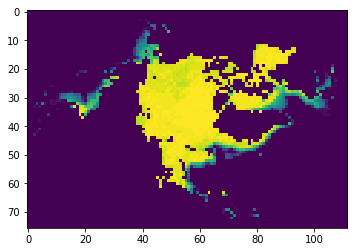

In [5]:
plt.imshow(resize_data(clean_data(np.load(all_data_files[3]))))

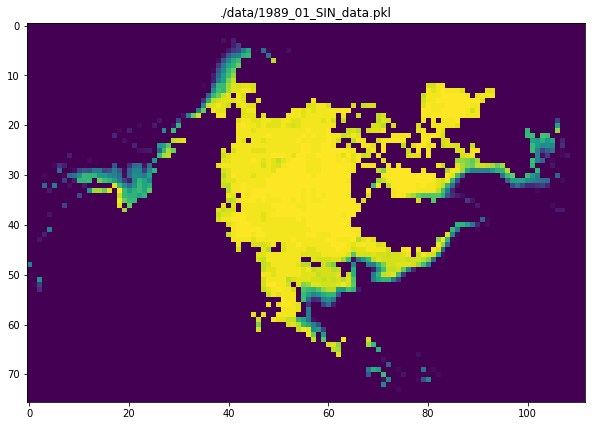

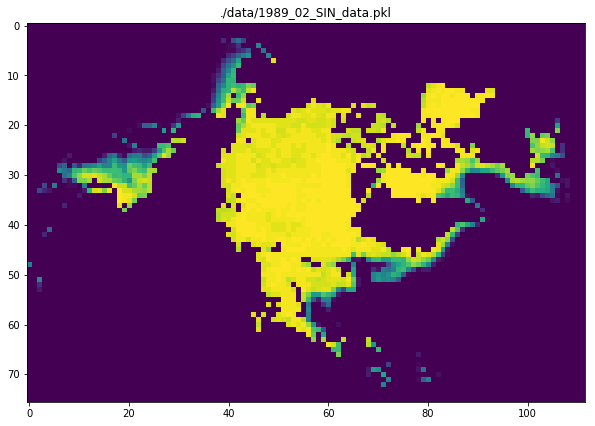

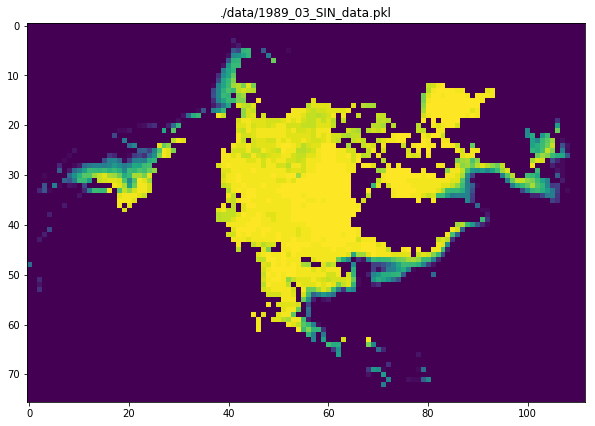

In [6]:
seqs = []
for d in all_data_files[:3]:
    data = clean_data(np.load(d))
    plt.figure(figsize=(10,10))
    plt.title(d)
    plt.imshow(resize_data(data))
    seqs.append(resize_data(data).flatten())

# Examining input data in context of LSTM

In [12]:
class ConvBlock(torch.nn.Module):
    
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 152
            torch.nn.Conv2d(8, 4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 76
            torch.nn.Conv2d(4, 2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(2, 1, kernel_size=1),
            torch.nn.ReLU()# 1x38x56
        )
    
    def forward(self, x):
        return self.conv_block(x)

    
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3,  padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            
            torch.nn.Conv2d(16, 8, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 1, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2))
        )
        self.decoder = nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, kernel_size=(2,2), stride=2),
            
            # b, 16, 5, 5
            torch.nn.Conv2d(16, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=(2,2), stride=2),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class AutoLSTM(torch.nn.Module):
    
    def __init__(self, encoder, decoder, input_dim, batch_size, hidden_dim, seq_length, num_layers, homology=False, N=75):
        super(AutoLSTM, self).__init__()
        
        # LSTM Variables.
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_size = input_dim
        
        # Homology info.
        self.homology = homology
        self.N = N
        
        # Encoder, decoder models.
        self.encoder = encoder
        self.decoder = decoder
        
        # Add the encoder to the model and turn off gradients for it.
        self.add_module('encoder', self.encoder)
        self.encoder.eval()
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Adding decoder letting model change up its gradients.
        self.add_module('decoder', self.decoder)
        self.decoder.eval()
        for param in self.decoder.parameters():
            param.requires_grad = False
            
        # Increase input for topo signatures.
        if self.homology:
            self.input_size = self.input_size + self.N*2
            self.slayer_dim0 = SLayer(self.N)
            self.slayer_dim1 = SLayer(self.N)
        else:
            self.N = 0
            
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers, 
                                  batch_first=True, dropout=.1)
        self.hidden = self.init_hidden()
        
    staticmethod
    def collation_station(batch):
        """
        Custom collation method for joining the batchs together
        based on seq length also.
        """
        # Collate X, and y batches as normal.
        X = torch.stack([torch.from_numpy(b[0]) for b in batch], 0)
        y = torch.stack([torch.from_numpy(b[-1]) for b in batch], 0)
        
        # For each batch prepare the dim0 and dim1 homology features together.
        dim0_batch = []
        dim1_batch = []
        for b in batch:
            dim0_batch += b[1]
            dim1_batch += b[2]
        dim0 = prepare_batch(dim0_batch)
        dim1 = prepare_batch(dim1_batch)
        return X, dim0, dim1, y
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device))
    
    def forward(self, x, dim0=torch.tensor([], device=device), dim1=torch.tensor([], device=device)):
        # X is (batch, seq, w, h)
        # Run inputs throuh conv nets.
        x = torch.cat([self.encoder(x[:, [ix], :, :]) for ix in range(self.seq_length)], dim=1)
        
        # Concatenate them.
        x = x.view(self.batch_size, self.seq_length, self.input_size - self.N*2)
        
        # Add the homology features.
        if self.homology:
            x = torch.cat([x, 
                           self.slayer_dim0(dim0).view(self.batch_size, self.seq_length, -1), 
                           self.slayer_dim1(dim1).view(self.batch_size, self.seq_length, -1)], dim=2)
            del dim0, dim1

        # Run through the lstm network.
        x, self.hidden = self.lstm(x, self.hidden)   
        
        # Run through the final decoder.
        x = self.decoder(x[:, -1, :].view(self.batch_size, 1, 19, 28))
        x = x.view(-1, 1, 8512)
        return x

In [ ]:
seq_length = 12
num_layers = 4
batch_size = 32
hidden_dim = 19*28
input_size = 19*28*1#432#9*14
hidden_dim = input_size
N = 10
n_epochs = 10

In [9]:
auto = torch.load('autoencoder_paperv4.model')

In [10]:
model = AutoLSTM(
    input_dim=input_size, seq_length=seq_length,
    hidden_dim=hidden_dim, batch_size=batch_size,
    num_layers=num_layers, encoder=auto.encoder, decoder=auto.decoder, N=N).to(device)

si_dataset = SeaIceDataset(seq_length)
train_loader = DataLoader(si_dataset, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)

# model = torch.load('good')

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

loss_mask = torch.tensor(np.load('resize_mask.npy').flatten().astype('float32')).cuda()

In [11]:
for epoch in range(n_epochs):
    print("epoch: {}".format(epoch))
    
    model.train()
    train_losses = []
    for ix, (X,  y) in enumerate(train_loader):
        # Empty out the grads.
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)

        out = model(X)
        
        
#         print("out_shape", out.shape)
#         print("y_shape", y.shape)
        loss = criterion(out*loss_mask, y*loss_mask)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())
        
        del out, X, y, loss
    
    print("loss: {}".format(train_losses[-1]))

epoch: 0


RuntimeError: lstm expects two hidden states

In [15]:
for X,y in train_loader:
    break

In [16]:
preds = model(X.to(device))

In [17]:
ix = 0

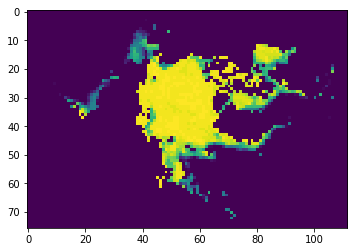

In [18]:
plt.imshow(X[ix, 9])

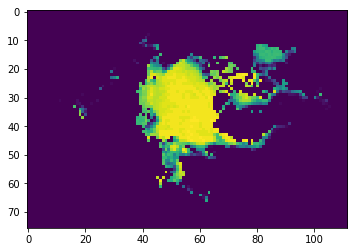

In [19]:
plt.imshow(X[ix, 10, :,:])

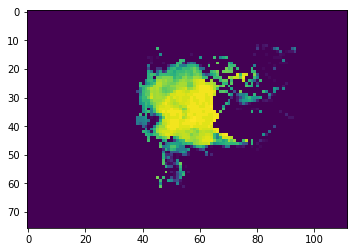

In [20]:
plt.imshow(X[ix, 11, :, :])

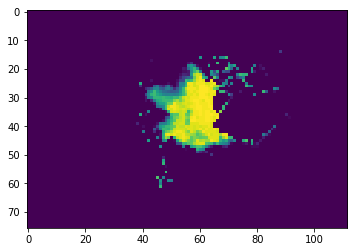

In [21]:
plt.imshow(y[ix].detach().numpy().reshape(76, 112))

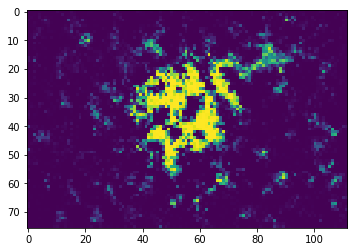

In [22]:
plt.imshow(preds[ix,:, :].cpu().detach().numpy().reshape(76, 112))